# Parametrized DNN
parametrized DNN 
1. Plot signal and background seperation
2. Include all signals
2. check the backgrounds.
3. Check the AUC score as this is coming 1
4. Improve the training
5. include the weight of preselection

In [1]:
import os
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# Taking mass X and corresponding Y mass points
# mass_points = [300, 400, 500, 550, 600, 650, 700, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 3500, 4000]  # Example mass points
# y_values = [ 60, 70, 80, 90, 95, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2600, 3000, 3500]  # Example Y values

mass_points = [300, 400, 500, 550, 600, 650, 700, 900, 1000]  # Example mass points
y_values = [ 100, 125, 150, 200, 300, 400, 500]  # Example Y values



# Load signal data from Parquet files
signal_data = []
for mass in mass_points:
    for y in y_values:
        file_path = f"../../../output_parquet/final_production_Syst/merged/NMSSM_X{mass}_Y{y}/nominal/NOTAG_merged.parquet"
        
        if os.path.exists(file_path):  # Check if file exists
            try:
                df = pd.read_parquet(file_path)  # Load the Parquet file
                df["mass"] = mass  
                df["y_value"] = y  # Store Y value if needed
                df["label"] = 1  # Assuming signal label
                signal_data.append(df)
            except Exception as e:
                print(f"Warning: Could not read {file_path}. Error: {e}")
        else:
            print(f"Warning: File {file_path} does not exist.")

# Combine all signal data into a single DataFrame
signal_df = pd.concat(signal_data, ignore_index=True) if signal_data else pd.DataFrame()

In [2]:
signal_df.shape

(346281, 853)

In [3]:
# Load background data from ROOT files
background_files = [
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt40/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GGJets/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt20To40/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt40/preselection"),
]
background_data = []
for file_path, tree_name in background_files:
    try:
        with uproot.open(file_path) as file:
            tree = file[tree_name]
            df = tree.arrays(library="pd")
            df["mass"] = np.random.choice(mass_points, len(df))  # Random mass assignment
            df["label"] = 0
            background_data.append(df)
    except Exception as e:
        print(f"Warning: Could not read {file_path}. Error: {e}")

df_background = pd.concat(background_data, ignore_index=True) if background_data else pd.DataFrame()

In [4]:
# Define features and labels
features = [
    'bbgg_eta', 'bbgg_phi', 'lead_pho_phi', 'sublead_pho_eta', 
    'sublead_pho_phi', 'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 
    'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 
    'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 
    'phosublead_PtOverM', 'lead_pho_mvaID', 'sublead_pho_mvaID'
]
features.extend(["mass", "y_value"])


In [5]:
# Random mass + y_value assignment for backgrounds (ensure this was done earlier!)
df_background["mass"] = np.random.choice(mass_points, len(df_background))
df_background["y_value"] = np.random.choice(y_values, len(df_background))


In [6]:

# Reduce background dataset size by random sampling
background_fraction = 0.1 #  20% of the background
df_background = df_background.sample(frac=background_fraction, random_state=42)

# Combine signal and background
df_combined = pd.concat([signal_df, df_background], ignore_index=True)

# Ensure df_combined is not empty
if df_combined.empty:
    raise ValueError("Error: Combined DataFrame is empty. Check input files.")

# Convert feature data to DataFrame to prevent AttributeError
df_features = df_combined[features]

# Fill missing values with column mean
df_features = df_features.fillna(df_features.mean())

# Extract features (X) and labels (y)
X = df_features.values
y = df_combined["label"].values

In [7]:
df_features.shape

(679375, 27)

In [8]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test (stratified to maintain label distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features (Fit only on train, transform both)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create Dataloader for training
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Optional: Create test dataloader if you want batch evaluation
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam

class ParameterizedDNN(nn.Module):
    def __init__(self, input_dim):
        super(ParameterizedDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),  # Helps stabilize training
            nn.Dropout(0.2),  # Reduce dropout

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),
            
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Dropout(0.1),  # Lower dropout to retain information
            
            nn.Linear(8, 1)  # Output layer (raw logits)
        )

    def forward(self, x):
        return self.model(x)


In [10]:
# Initialize model
input_dim = X.shape[1]
model = ParameterizedDNN(input_dim)
criterion = nn.BCEWithLogitsLoss()  # Expecting raw logits
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Reduce learning rate


In [11]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
train_losses = []
train_accuracies = []
train_aucs = []
fpr_all, tpr_all, thresholds_all = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    y_true_train, y_pred_train = [], []
    
    for batch in train_dataloader:
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    # Convert predictions to binary
    y_pred_train_binary = [1 if p > 0.5 else 0 for p in y_pred_train]
    train_accuracy = accuracy_score(y_true_train, y_pred_train_binary)
    train_auc = roc_auc_score(y_true_train, y_pred_train)

    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor.to(device)).squeeze()
        y_pred_test = torch.sigmoid(outputs_test).cpu().numpy()
        test_loss = criterion(outputs_test, y_test_tensor.to(device)).item()
        
        y_pred_test_binary = [1 if p > 0.5 else 0 for p in y_pred_test]
        test_accuracy = accuracy_score(y_test, y_pred_test_binary)
        test_auc = roc_auc_score(y_test, y_pred_test)

    # Print Progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {epoch_loss / len(train_dataloader):.4f} | Train Acc: {train_accuracy:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f} | Test AUC: {test_auc:.4f}")


Epoch [1/10]
Train Loss: 0.0102 | Train Acc: 0.9991 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.0000 | Test AUC: 1.0000
Epoch [2/10]
Train Loss: 0.0002 | Train Acc: 1.0000 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.0000 | Test AUC: 1.0000
Epoch [3/10]
Train Loss: 0.0001 | Train Acc: 1.0000 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.0000 | Test AUC: 1.0000
Epoch [4/10]
Train Loss: 0.0001 | Train Acc: 1.0000 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.0000 | Test AUC: 1.0000
Epoch [5/10]
Train Loss: 0.0002 | Train Acc: 1.0000 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.0000 | Test AUC: 1.0000
Epoch [6/10]
Train Loss: 0.0002 | Train Acc: 1.0000 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.0000 | Test AUC: 1.0000
Epoch [7/10]
Train Loss: 0.0001 | Train Acc: 1.0000 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.0000 | Test AUC: 1.0000
Epoch [8/10]
Train Loss: 0.0002 | Train Acc: 1.0000 | Train AUC: 1.0000
Test Loss: 0.0000 | Test Acc: 1.

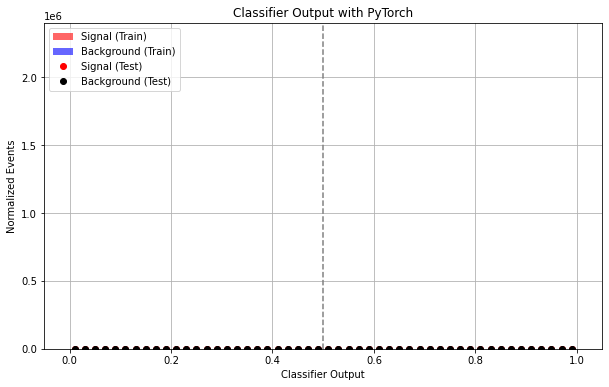

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model outputs on the full dataset
model.eval()
with torch.no_grad():
    y_pred_train_scores = torch.sigmoid(model(X_train_tensor.to(device))).cpu().numpy().flatten()
    y_pred_test_scores = torch.sigmoid(model(X_test_tensor.to(device))).cpu().numpy().flatten()

# Plot histograms
plt.figure(figsize=(10, 6))

# Training scores
plt.hist(y_pred_train_scores[y_train == 1], bins=50, alpha=0.6, label='Signal (Train)', color='red', histtype='stepfilled', density=True)
plt.hist(y_pred_train_scores[y_train == 0], bins=50, alpha=0.6, label='Background (Train)', color='blue', histtype='stepfilled', density=True)

# Test scores: Compute histograms, then plot centers
def plot_points(y_scores, label, color):
    counts, bins = np.histogram(y_scores, bins=50, range=(0, 1), density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, counts, f'{color}o', label=label)

plot_points(y_pred_test_scores[y_test == 1], 'Signal (Test)', 'r')
plot_points(y_pred_test_scores[y_test == 0], 'Background (Test)', 'k')

# Aesthetics
plt.axvline(0.5, color='gray', linestyle='--')
plt.xlabel("Classifier Output")
plt.ylabel("Normalized Events")
plt.title("Classifier Output with PyTorch")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(df_combined['label'].value_counts())


In [ ]:
# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")


plt.tight_layout()
plt.show()

In [ ]:
# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', linestyle='-', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")

plt.tight_layout()
plt.show()


In [ ]:
# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_aucs, marker='o', linestyle='-', color='red')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC vs. Epochs")


plt.tight_layout()
plt.show()

In [ ]:
# Plot AUC scores over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_aucs, label="AUC", color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Score over Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:


# Plot the final ROC curve
# Select the ROC curve from the last epoch
fpr_last = fpr_all[-1]
tpr_last = tpr_all[-1]

plt.figure(figsize=(10, 6))
plt.plot(fpr_last, tpr_last, color='darkorange', lw=2, label=f'ROC curve (AUC = {train_aucs[-1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Final ROC Curve (AUC = {train_aucs[-1]:.2f})')
plt.legend(loc="lower right")
plt.show()